In [1]:
%pylab inline

import sys
import os
par_dir = os.path.split(os.getcwd())[0]
if par_dir not in sys.path:
    sys.path.append(par_dir)
# sys.path.append(r'/Users/artemgolovizin/GitHub')
from scipy.optimize import curve_fit
import inspect
import pickle
import imp
import re
import json

# from IPython.html import widgets
# from IPython.display import display
# from IPython.html.widgets import interact, interactive, fixed

from IPython import parallel

import thulium_python_lib.image_processing_new as impr
rc1 = parallel.Client()
lview = rc1.load_balanced_view()
dview = rc1.direct_view()
with dview.sync_imports():
    import sys, os    
dview['par_dir'] = par_dir
%px if par_dir not in sys.path: sys.path.append(par_dir)
#%px if r'/Users/artemgolovizin/GitHub' not in sys.path: sys.path.append(r'/Users/artemgolovizin/GitHub')
%px import thulium_python_lib.image_processing_new as impr
%px import imp
%px from IPython.parallel import bind_kernel; bind_kernel()

Populating the interactive namespace from numpy and matplotlib
Done importing, module image_processing now
importing sys on engine(s)
importing os on engine(s)
[stdout:0] Done importing, module image_processing now
[stdout:1] Done importing, module image_processing now
[stdout:2] Done importing, module image_processing now
[stdout:3] Done importing, module image_processing now


In [2]:
# to reload library on remote and local engine
# %px imp.reload(impr)
# imp.reload(impr)

In [719]:
def exp_decay(t, N0, tau, background):
    return N0 * exp(- t / tau) + background
def exp_decay_no_bg(t, N0, tau):
    return N0 * exp(- t / tau)
def cloud_expansion(t, T, r0, t0):
    k_b = 1.38e-23
    m = 169 * 1.66e-27
    return sqrt(r0**2 + 2 * k_b * abs(T) * (t + 0*t0)**2 / m)
def exp_grouth(t, N0, tau, background):
    return N0 * ( 1 - exp( - t / tau)) + 0*background
# function to convert arbitrary units to atoms number
convert_N_atoms = impr.N_atoms(width=0.5, delta = 5)

def construct_fit_description(fit_func, popt_T):
    """constructs a set of string of type 'variable=value\n' for all [1:] function variables"""
    res = ''
    for item in zip(inspect.getargspec(fit_func)[0][1:], popt_T):
#         res += str(item[0]) + ' = ' + "%.2f"%(item[1]) + '\n'
        res += str(item[0]) + ' = ' + str(item[1]) + '\n'
    res = res.rstrip('\n')
    return res

### And now:
#####Constract loader and averager. For available parameters see help('instance')

In [720]:
loader  = impr.Load_Image(dview)
averager = impr.Avr_Image(dview,do_sifting=False)

####Choose working directory and measurement folder

In [721]:
# smth like 'D:\!Data\2015_08_20' for lab and like '/Users/artemgolovizin/Downloads/2015_08_20' for mac
os.chdir(r'\\BIGONE\!Data\2015_07_01')
# print('Current directory', os.getcwd());
# Create folder 'Figures' for saving individual plot
if not os.path.exists('Figures'):
    os.makedirs('Figures')
    print('Folder Figures has been created')
    
working_directory = ''
folder = ''

In [1059]:
folder = '18 364.54/'
working_directory = os.path.join(os.getcwd(),folder)
# print('Working directory', working_directory)

dirs = [x for x in os.listdir() if re.match('\d',x)]
x_lbl, y_lbl, xaxis_calib = impr.get_x_calibration(folder, dirs)

### Load data, rearange, average and calibrate

In [1060]:
# downloading images
all_data = loader(working_directory,lview)

# rearranging to dictionary
dataD = impr.rearrange_data(all_data)

# sifting(filtering) data - removing empty images  !!! DOES NOTE WORKS NOW
#impr.sift(dataD)

  50/50 tasks finished after    0 s
done

Total number of images:  50
Rearranging to dictionary is complited


In [1061]:
# averaging data
avr_dataD = averager(dataD,lview)

# construct new data dictionary without image and calibration atoms number, size and x-axis
navrD = impr.mod_avrData(avr_dataD, xaxis_calib, convert_N_atoms, impr.real_size)


# for plotting sifted image
#imshow(imread('1 от частоты амплитудной модуляции аома верди (5) 3.9W/26ms/2_1.png'))
#colorbar()

   5/5 tasks finished after    0 s
done



### Construct data based on measurement type and plot

Fit parameters X, Y:
T = (36.787236846802195, 75.969442472321461)
r0 = (101.26062100618606, 111.79806566635764)
t0 = (0.0, 0.0)


C:\Program Files\Anaconda\lib\site-packages\scipy\optimize\minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


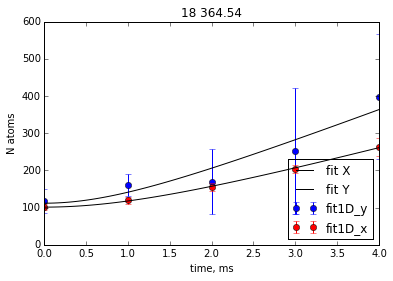

In [1062]:
# find measurement type to automatically plot needed data
meas_type = re.findall('\d+\s+(\w+)',folder)
meas_type = 'LT' if len(meas_type) ==0 else meas_type[0].upper()

# shot_typeN - for now only 1, if there will be calibration - 1 or more
shot_typeN = 1

# description to add to all_data.txt file
description = dict()
description['meas_type'] = meas_type
description['x_label'] = x_lbl
description['y_label'] = y_lbl

fig1, ax1 = subplots()
meas_type = 'T'
if meas_type == 'T':
    # construct data with cloud expansion on both coordinates
    # first set of data  - Temperature X
    d1 = impr.get_avr_data(navrD, shot_typeN, 'fit1D_x',2)
    d1['fmt']='ro'
    d1['label']='fit1D_x'
    #impr.drop_by_number(d1,5)
    #impr.drop_by_x(d1,130,160)

    # second set of data  - Temperature Y
    d2 = impr.get_avr_data(navrD, shot_typeN,  'fit1D_y',2)
    d2['fmt']='bo'
    d2['label'] = 'fit1D_y'
    #impr.drop_by_number(d2,5)
    
    # fit cloud expansion
    fit_func = cloud_expansion
    popt_T, pcov_T = curve_fit(fit_func, d1['x'], d1['y'], p0=(d1['y'][0],20,0))
    popt_T2, pcov_T2 = curve_fit(fit_func, d2['x'], d2['y'], p0=(d2['y'][0], 20,0))
    print('Fit parameters X, Y:\n' + construct_fit_description(fit_func, list(zip(popt_T,popt_T2))))
    
    # plot data and fits  ADD T VALUE ON PLOT
    ax1.errorbar(**d2)
    ax1.errorbar(**d1)
    ax1.plot(linspace(min(d1['x']),max(d1['x']),100), fit_func(linspace(min(d1['x']),max(d1['x']),100),*popt_T),'k', label='fit X')
    ax1.plot(linspace(min(d2['x']),max(d2['x']),100), fit_func(linspace(min(d2['x']),max(d2['x']),100),*popt_T2),'k', label='fit Y')
    
    # add information about fits to description
    description['fit1D_x'] =  popt_T
    description['fit1D_y'] =  popt_T2
    description['fit-function'] = fit_func.__name__
    
else:
    # construct data, param - what value to use
    param = 'fit1D_x'
    d1 = impr.get_avr_data(navrD, shot_typeN, param,0)
    d1['fmt']='ro'
    d1['label']=param
    #impr.drop_by_number(d1,*range(20,len(d1['x'])))
    #impr.drop_by_x(d1,130,160)
    
    # fit_func - which function to use to fit data  here one can put conditions on meas_type to choose fit
    popt_T = None
    fit_func = exp_decay
    popt_T, pcov_T = curve_fit(fit_func, d1['x'], d1['y'], p0=(d1['y'][0], 100,0))
    #popt_T, pcov_T = curve_fit(fit_func, d1['x'], d1['y'], p0=(-d1['y'][0], d1['x'][argmin(d1['y'])],0.1,d1['y'][0]))
    print('Fit parameters:\n' + construct_fit_description(fit_func, popt_T))
    
    # plot data and fits
    ax1.errorbar(**d1)
    if(fit_func != None):
        ax1.plot(linspace(min(d1['x']),max(d1['x']),100), fit_func(linspace(min(d1['x']),max(d1['x']),100),*popt_T),'k', label='fit X')
    if fit_func != None:
        fit_label = fit_func.__name__ + ' fit:\n' + construct_fit_description(fit_func, popt_T)
        ax1.text(0.01,0.01,fit_label,transform=ax1.transAxes)
    
    description['fit'] =  popt_T
    description['fit-function'] = fit_func.__name__
    
ax1.set_xlabel(x_lbl)
ax1.set_ylabel(y_lbl)
ax1.set_title(folder.rstrip(r'\/ '))
ax1.set_ylim(bottom=0)
ax1.legend(loc=4)

<Container object of 3 artists>

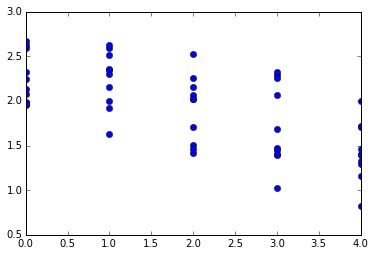

In [1063]:
# for each picture
d3 = dict()
d3['x'],d3['y'] = impr.constract_data(dataD, shot_typeN, 'fit1D_x',0)

fig2, ax2 = subplots()
ax2.errorbar(fmt='o',**d3)

In [1064]:
if folder != '':
    fig1.savefig(os.path.join('Figures',folder.rstrip(r'\/ ')+'.png'))
    try:
        with open('all_data.txt', 'rb') as handle:
            res_dict = pickle.loads(handle.read())
    except FileNotFoundError:
        res_dict = {}
    except EOFError:
        res_dict = {}
    res_dict[folder.rstrip(r'\/ ')]={'description':description,'data':navrD}
    with open('all_data.txt', 'wb') as handle:
        pickle.dump(res_dict, handle)
    with open('all_data.json', 'w') as outfile:
        json.dump(res_dict, outfile, cls=impr.JsonCustomEncoder, indent=4)    
    print('Figure and data saved!!!')
    
# to later read json file run following two lines
#with open('all_data.json', 'r') as infile:
#        ddata = json.load(infile)

Figure and data saved!!!


In [1065]:
perr = np.sqrt(np.diag(pcov_T))
perr

array([ inf,  inf,  inf])

In [1066]:
perr = np.sqrt(np.diag(pcov_T2))
perr

array([ inf,  inf,  inf])

##### 